# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

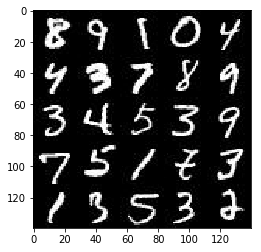

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

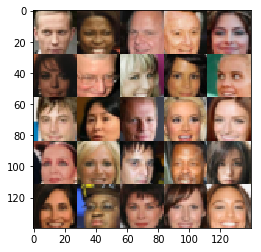

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/home/jthoms/anaconda3/envs/dog-project/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learning_rate_t = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    i = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                i += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
            
                _ = sess.run(d_train_opt, feed_dict={input_real:batch_images, input_z:batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real:batch_images, input_z:batch_z})
  
                if i%10 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if i%100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5413... Generator Loss: 1.4976
Epoch 1/2... Discriminator Loss: 3.3262... Generator Loss: 0.0506
Epoch 1/2... Discriminator Loss: 0.4962... Generator Loss: 1.7514
Epoch 1/2... Discriminator Loss: 1.3486... Generator Loss: 1.0388
Epoch 1/2... Discriminator Loss: 1.4277... Generator Loss: 0.9019
Epoch 1/2... Discriminator Loss: 2.3554... Generator Loss: 1.3883
Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 0.4506
Epoch 1/2... Discriminator Loss: 0.8408... Generator Loss: 2.2096
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 2.4117
Epoch 1/2... Discriminator Loss: 1.6590... Generator Loss: 1.2990


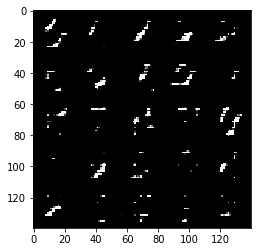

Epoch 1/2... Discriminator Loss: 1.2261... Generator Loss: 2.4091
Epoch 1/2... Discriminator Loss: 1.6200... Generator Loss: 2.7147
Epoch 1/2... Discriminator Loss: 1.6478... Generator Loss: 0.3339
Epoch 1/2... Discriminator Loss: 2.5092... Generator Loss: 0.1193
Epoch 1/2... Discriminator Loss: 1.1793... Generator Loss: 1.8510
Epoch 1/2... Discriminator Loss: 2.0946... Generator Loss: 2.0476
Epoch 1/2... Discriminator Loss: 1.2002... Generator Loss: 0.7632
Epoch 1/2... Discriminator Loss: 1.2160... Generator Loss: 0.6263
Epoch 1/2... Discriminator Loss: 1.7304... Generator Loss: 3.2479
Epoch 1/2... Discriminator Loss: 0.9133... Generator Loss: 0.8430


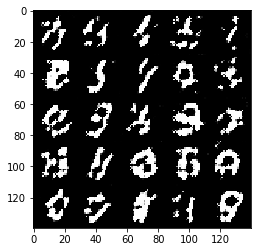

Epoch 1/2... Discriminator Loss: 0.6858... Generator Loss: 1.0534
Epoch 1/2... Discriminator Loss: 1.0899... Generator Loss: 2.0741
Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 1.2858
Epoch 1/2... Discriminator Loss: 2.3272... Generator Loss: 0.1311
Epoch 1/2... Discriminator Loss: 2.1742... Generator Loss: 0.1822
Epoch 1/2... Discriminator Loss: 1.1984... Generator Loss: 0.6422
Epoch 1/2... Discriminator Loss: 2.4399... Generator Loss: 4.4105
Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 0.6774
Epoch 1/2... Discriminator Loss: 0.8854... Generator Loss: 1.9471
Epoch 1/2... Discriminator Loss: 1.4608... Generator Loss: 0.9868


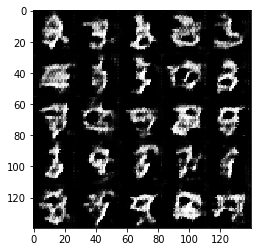

Epoch 1/2... Discriminator Loss: 2.2085... Generator Loss: 0.2079
Epoch 1/2... Discriminator Loss: 0.8982... Generator Loss: 1.0696
Epoch 1/2... Discriminator Loss: 1.2246... Generator Loss: 0.6246
Epoch 1/2... Discriminator Loss: 1.3527... Generator Loss: 0.6547
Epoch 1/2... Discriminator Loss: 1.7956... Generator Loss: 0.3262
Epoch 1/2... Discriminator Loss: 1.1061... Generator Loss: 0.7333
Epoch 1/2... Discriminator Loss: 1.2440... Generator Loss: 1.1968
Epoch 1/2... Discriminator Loss: 1.2986... Generator Loss: 0.5588
Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 0.7568
Epoch 1/2... Discriminator Loss: 1.0913... Generator Loss: 0.6968


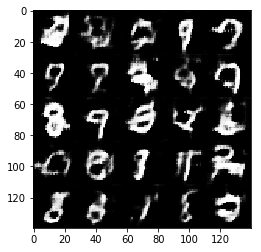

Epoch 1/2... Discriminator Loss: 1.1378... Generator Loss: 0.7474
Epoch 1/2... Discriminator Loss: 1.2076... Generator Loss: 0.5586
Epoch 1/2... Discriminator Loss: 1.1034... Generator Loss: 1.4220
Epoch 1/2... Discriminator Loss: 1.2995... Generator Loss: 0.5635
Epoch 1/2... Discriminator Loss: 1.4787... Generator Loss: 0.4308
Epoch 1/2... Discriminator Loss: 0.9535... Generator Loss: 0.8281
Epoch 1/2... Discriminator Loss: 1.0398... Generator Loss: 0.9644
Epoch 1/2... Discriminator Loss: 1.1038... Generator Loss: 0.9836
Epoch 1/2... Discriminator Loss: 1.3961... Generator Loss: 1.8789
Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 1.3079


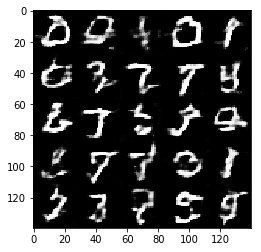

Epoch 1/2... Discriminator Loss: 1.4418... Generator Loss: 0.3954
Epoch 1/2... Discriminator Loss: 1.0379... Generator Loss: 0.6849
Epoch 1/2... Discriminator Loss: 0.9726... Generator Loss: 1.3750
Epoch 1/2... Discriminator Loss: 1.3067... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 2.0306... Generator Loss: 0.2443
Epoch 1/2... Discriminator Loss: 1.0410... Generator Loss: 0.7139
Epoch 1/2... Discriminator Loss: 1.0863... Generator Loss: 0.9007
Epoch 1/2... Discriminator Loss: 1.3908... Generator Loss: 1.2922
Epoch 1/2... Discriminator Loss: 1.1061... Generator Loss: 0.6873
Epoch 1/2... Discriminator Loss: 1.0857... Generator Loss: 0.8497


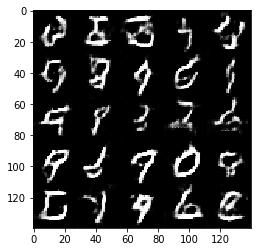

Epoch 1/2... Discriminator Loss: 1.1635... Generator Loss: 1.0209
Epoch 1/2... Discriminator Loss: 1.0181... Generator Loss: 1.0578
Epoch 1/2... Discriminator Loss: 1.0256... Generator Loss: 0.9084
Epoch 1/2... Discriminator Loss: 1.1084... Generator Loss: 0.7078
Epoch 1/2... Discriminator Loss: 0.9123... Generator Loss: 1.2829
Epoch 1/2... Discriminator Loss: 1.1973... Generator Loss: 1.5296
Epoch 1/2... Discriminator Loss: 1.1133... Generator Loss: 0.7470
Epoch 1/2... Discriminator Loss: 1.1350... Generator Loss: 0.6459
Epoch 1/2... Discriminator Loss: 3.2750... Generator Loss: 3.5783
Epoch 1/2... Discriminator Loss: 1.6354... Generator Loss: 0.2973


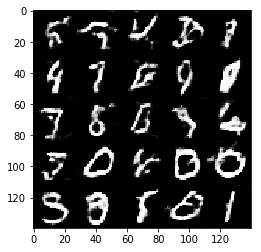

Epoch 1/2... Discriminator Loss: 1.0651... Generator Loss: 0.6569
Epoch 1/2... Discriminator Loss: 1.0201... Generator Loss: 1.7219
Epoch 1/2... Discriminator Loss: 1.2417... Generator Loss: 2.1051
Epoch 1/2... Discriminator Loss: 1.6609... Generator Loss: 1.3894
Epoch 1/2... Discriminator Loss: 1.9149... Generator Loss: 2.3427
Epoch 1/2... Discriminator Loss: 1.0678... Generator Loss: 0.6797
Epoch 1/2... Discriminator Loss: 1.1212... Generator Loss: 1.2585
Epoch 1/2... Discriminator Loss: 1.1583... Generator Loss: 0.9246
Epoch 1/2... Discriminator Loss: 1.0262... Generator Loss: 0.9811
Epoch 1/2... Discriminator Loss: 0.7961... Generator Loss: 1.5619


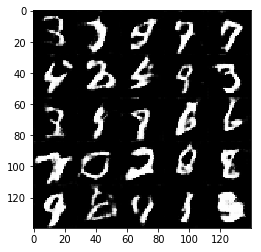

Epoch 1/2... Discriminator Loss: 0.7629... Generator Loss: 1.4926
Epoch 1/2... Discriminator Loss: 2.7169... Generator Loss: 0.1401
Epoch 1/2... Discriminator Loss: 1.1259... Generator Loss: 1.0510
Epoch 1/2... Discriminator Loss: 1.0751... Generator Loss: 0.6160
Epoch 1/2... Discriminator Loss: 0.7143... Generator Loss: 1.2788
Epoch 1/2... Discriminator Loss: 1.0561... Generator Loss: 0.7244
Epoch 1/2... Discriminator Loss: 1.8199... Generator Loss: 0.2457
Epoch 1/2... Discriminator Loss: 1.0530... Generator Loss: 0.6692
Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 0.6776
Epoch 1/2... Discriminator Loss: 1.2117... Generator Loss: 1.5529


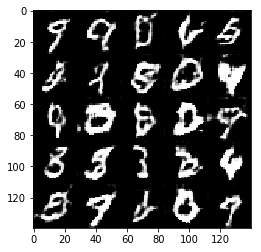

Epoch 1/2... Discriminator Loss: 1.1820... Generator Loss: 0.6005
Epoch 1/2... Discriminator Loss: 0.9476... Generator Loss: 2.2382
Epoch 1/2... Discriminator Loss: 1.7356... Generator Loss: 0.3277
Epoch 1/2... Discriminator Loss: 0.8678... Generator Loss: 1.0161
Epoch 1/2... Discriminator Loss: 0.7593... Generator Loss: 1.3258
Epoch 1/2... Discriminator Loss: 1.4639... Generator Loss: 0.7316
Epoch 1/2... Discriminator Loss: 0.9869... Generator Loss: 1.3977
Epoch 1/2... Discriminator Loss: 1.3599... Generator Loss: 0.4322
Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.5609
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 0.7269


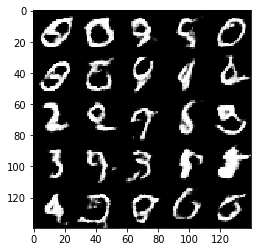

Epoch 1/2... Discriminator Loss: 1.0131... Generator Loss: 1.2564
Epoch 1/2... Discriminator Loss: 1.0484... Generator Loss: 0.7191
Epoch 1/2... Discriminator Loss: 1.6671... Generator Loss: 0.3170
Epoch 1/2... Discriminator Loss: 1.5043... Generator Loss: 0.4115
Epoch 1/2... Discriminator Loss: 1.9846... Generator Loss: 0.3075
Epoch 1/2... Discriminator Loss: 1.8989... Generator Loss: 3.0042
Epoch 1/2... Discriminator Loss: 0.8935... Generator Loss: 1.0269
Epoch 1/2... Discriminator Loss: 0.8060... Generator Loss: 0.9399
Epoch 1/2... Discriminator Loss: 0.9113... Generator Loss: 0.6730
Epoch 1/2... Discriminator Loss: 1.2451... Generator Loss: 0.5494


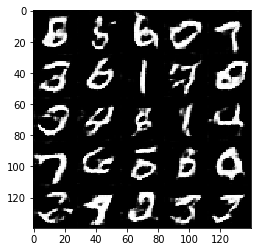

Epoch 1/2... Discriminator Loss: 1.1009... Generator Loss: 0.7390
Epoch 1/2... Discriminator Loss: 1.0572... Generator Loss: 0.6029
Epoch 1/2... Discriminator Loss: 1.4402... Generator Loss: 0.4097
Epoch 1/2... Discriminator Loss: 0.9837... Generator Loss: 1.2906
Epoch 1/2... Discriminator Loss: 1.7951... Generator Loss: 0.3093
Epoch 1/2... Discriminator Loss: 0.7184... Generator Loss: 1.2392
Epoch 1/2... Discriminator Loss: 1.0401... Generator Loss: 0.7017
Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 0.8728
Epoch 1/2... Discriminator Loss: 1.0242... Generator Loss: 0.6057
Epoch 1/2... Discriminator Loss: 0.7500... Generator Loss: 1.1584


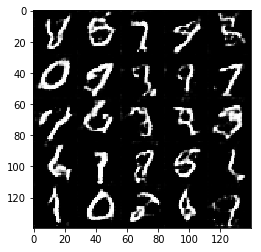

Epoch 1/2... Discriminator Loss: 0.5878... Generator Loss: 1.6074
Epoch 1/2... Discriminator Loss: 1.0804... Generator Loss: 1.9094
Epoch 1/2... Discriminator Loss: 0.8284... Generator Loss: 2.1884
Epoch 1/2... Discriminator Loss: 0.5453... Generator Loss: 1.4905
Epoch 1/2... Discriminator Loss: 0.7544... Generator Loss: 1.5159
Epoch 1/2... Discriminator Loss: 1.0358... Generator Loss: 0.6693
Epoch 1/2... Discriminator Loss: 1.1252... Generator Loss: 2.3190
Epoch 1/2... Discriminator Loss: 1.4452... Generator Loss: 0.3849
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 0.6173
Epoch 1/2... Discriminator Loss: 0.6838... Generator Loss: 1.5446


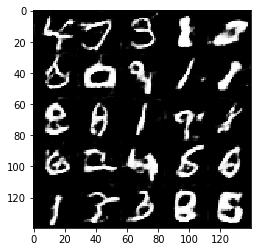

Epoch 1/2... Discriminator Loss: 0.4744... Generator Loss: 1.7015
Epoch 1/2... Discriminator Loss: 1.6180... Generator Loss: 0.3826
Epoch 1/2... Discriminator Loss: 0.7267... Generator Loss: 1.1905
Epoch 1/2... Discriminator Loss: 1.3022... Generator Loss: 0.5094
Epoch 1/2... Discriminator Loss: 1.6977... Generator Loss: 0.5486
Epoch 1/2... Discriminator Loss: 1.8437... Generator Loss: 0.3326
Epoch 1/2... Discriminator Loss: 1.9656... Generator Loss: 0.2582
Epoch 1/2... Discriminator Loss: 0.7928... Generator Loss: 1.0184
Epoch 1/2... Discriminator Loss: 0.6294... Generator Loss: 1.0926
Epoch 1/2... Discriminator Loss: 0.9029... Generator Loss: 0.8124


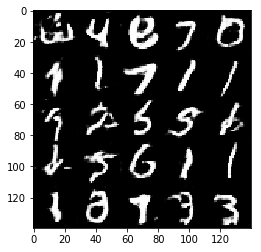

Epoch 1/2... Discriminator Loss: 1.6716... Generator Loss: 0.3304
Epoch 1/2... Discriminator Loss: 0.7112... Generator Loss: 1.8939
Epoch 1/2... Discriminator Loss: 1.2874... Generator Loss: 0.6770
Epoch 1/2... Discriminator Loss: 0.7018... Generator Loss: 1.0133
Epoch 1/2... Discriminator Loss: 0.7478... Generator Loss: 1.0322
Epoch 1/2... Discriminator Loss: 1.0508... Generator Loss: 0.6373
Epoch 1/2... Discriminator Loss: 0.4529... Generator Loss: 1.6454
Epoch 1/2... Discriminator Loss: 1.4542... Generator Loss: 0.3966
Epoch 1/2... Discriminator Loss: 0.6154... Generator Loss: 1.3503
Epoch 1/2... Discriminator Loss: 0.6145... Generator Loss: 1.3756


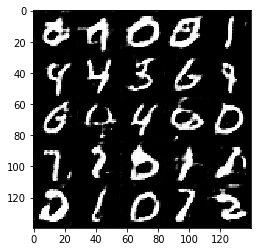

Epoch 1/2... Discriminator Loss: 0.4191... Generator Loss: 1.5276
Epoch 1/2... Discriminator Loss: 1.0483... Generator Loss: 0.7689
Epoch 1/2... Discriminator Loss: 0.8954... Generator Loss: 1.3041
Epoch 1/2... Discriminator Loss: 0.7673... Generator Loss: 1.9224
Epoch 1/2... Discriminator Loss: 1.2180... Generator Loss: 0.5187
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 0.7699
Epoch 1/2... Discriminator Loss: 0.6686... Generator Loss: 1.1562
Epoch 1/2... Discriminator Loss: 1.2872... Generator Loss: 0.5388
Epoch 1/2... Discriminator Loss: 0.8460... Generator Loss: 1.0024
Epoch 1/2... Discriminator Loss: 2.3194... Generator Loss: 0.1685


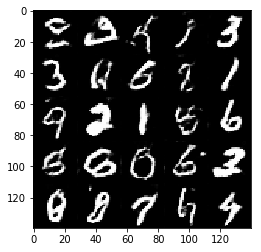

Epoch 1/2... Discriminator Loss: 0.4795... Generator Loss: 2.3025
Epoch 1/2... Discriminator Loss: 1.6203... Generator Loss: 0.4121
Epoch 1/2... Discriminator Loss: 0.8799... Generator Loss: 1.5140
Epoch 1/2... Discriminator Loss: 0.8755... Generator Loss: 2.0800
Epoch 1/2... Discriminator Loss: 1.3649... Generator Loss: 0.4601
Epoch 1/2... Discriminator Loss: 1.6402... Generator Loss: 0.3174
Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 3.4210
Epoch 1/2... Discriminator Loss: 2.5443... Generator Loss: 0.2864
Epoch 1/2... Discriminator Loss: 0.7977... Generator Loss: 0.9782
Epoch 1/2... Discriminator Loss: 0.5194... Generator Loss: 1.6432


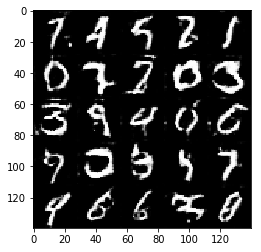

Epoch 1/2... Discriminator Loss: 0.8072... Generator Loss: 0.9047
Epoch 1/2... Discriminator Loss: 0.4041... Generator Loss: 1.8238
Epoch 1/2... Discriminator Loss: 0.3509... Generator Loss: 2.2151
Epoch 1/2... Discriminator Loss: 0.9053... Generator Loss: 4.4068
Epoch 1/2... Discriminator Loss: 0.8345... Generator Loss: 0.9573
Epoch 1/2... Discriminator Loss: 1.1182... Generator Loss: 0.6023
Epoch 1/2... Discriminator Loss: 0.4164... Generator Loss: 1.9414
Epoch 1/2... Discriminator Loss: 0.4545... Generator Loss: 1.8046
Epoch 1/2... Discriminator Loss: 0.4827... Generator Loss: 2.6685
Epoch 1/2... Discriminator Loss: 1.2722... Generator Loss: 0.5415


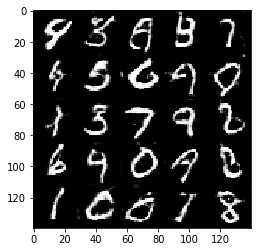

Epoch 1/2... Discriminator Loss: 2.0081... Generator Loss: 0.3098
Epoch 1/2... Discriminator Loss: 1.3305... Generator Loss: 0.4751
Epoch 1/2... Discriminator Loss: 0.6738... Generator Loss: 1.2403
Epoch 1/2... Discriminator Loss: 0.9811... Generator Loss: 2.1988
Epoch 1/2... Discriminator Loss: 1.2258... Generator Loss: 0.6876
Epoch 1/2... Discriminator Loss: 0.5939... Generator Loss: 1.2278
Epoch 1/2... Discriminator Loss: 0.6353... Generator Loss: 1.2927
Epoch 2/2... Discriminator Loss: 1.2504... Generator Loss: 0.6078
Epoch 2/2... Discriminator Loss: 0.7517... Generator Loss: 1.0199
Epoch 2/2... Discriminator Loss: 0.6164... Generator Loss: 2.0758


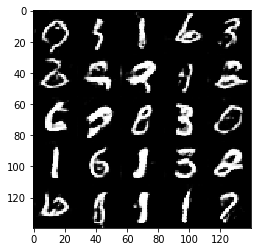

Epoch 2/2... Discriminator Loss: 0.2847... Generator Loss: 2.2562
Epoch 2/2... Discriminator Loss: 0.6087... Generator Loss: 1.1242
Epoch 2/2... Discriminator Loss: 0.3084... Generator Loss: 1.9177
Epoch 2/2... Discriminator Loss: 0.8988... Generator Loss: 0.7590
Epoch 2/2... Discriminator Loss: 1.7192... Generator Loss: 0.3771
Epoch 2/2... Discriminator Loss: 1.5906... Generator Loss: 0.4599
Epoch 2/2... Discriminator Loss: 2.5391... Generator Loss: 0.1632
Epoch 2/2... Discriminator Loss: 1.1211... Generator Loss: 4.0297
Epoch 2/2... Discriminator Loss: 1.2974... Generator Loss: 0.5269
Epoch 2/2... Discriminator Loss: 0.7390... Generator Loss: 1.4746


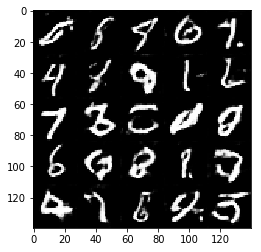

Epoch 2/2... Discriminator Loss: 1.5083... Generator Loss: 0.3761
Epoch 2/2... Discriminator Loss: 0.5816... Generator Loss: 1.4349
Epoch 2/2... Discriminator Loss: 0.4725... Generator Loss: 2.2884
Epoch 2/2... Discriminator Loss: 0.9780... Generator Loss: 1.0195
Epoch 2/2... Discriminator Loss: 0.4055... Generator Loss: 2.3278
Epoch 2/2... Discriminator Loss: 1.3022... Generator Loss: 2.5917
Epoch 2/2... Discriminator Loss: 1.9008... Generator Loss: 0.4782
Epoch 2/2... Discriminator Loss: 0.7379... Generator Loss: 0.9582
Epoch 2/2... Discriminator Loss: 1.2548... Generator Loss: 0.6482
Epoch 2/2... Discriminator Loss: 1.5402... Generator Loss: 0.4180


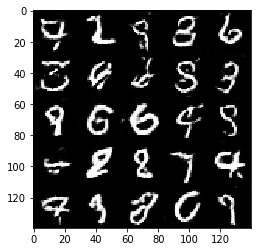

Epoch 2/2... Discriminator Loss: 0.6913... Generator Loss: 1.2271
Epoch 2/2... Discriminator Loss: 1.1484... Generator Loss: 0.6909
Epoch 2/2... Discriminator Loss: 0.6745... Generator Loss: 1.4776
Epoch 2/2... Discriminator Loss: 2.3060... Generator Loss: 5.9728
Epoch 2/2... Discriminator Loss: 0.6176... Generator Loss: 1.1891
Epoch 2/2... Discriminator Loss: 0.7694... Generator Loss: 1.1729
Epoch 2/2... Discriminator Loss: 0.5823... Generator Loss: 1.3460
Epoch 2/2... Discriminator Loss: 1.2188... Generator Loss: 0.5414
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 0.6100
Epoch 2/2... Discriminator Loss: 0.6619... Generator Loss: 1.1269


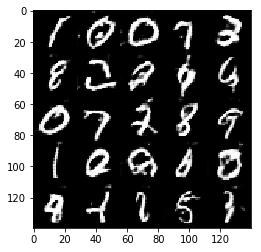

Epoch 2/2... Discriminator Loss: 3.3970... Generator Loss: 0.1449
Epoch 2/2... Discriminator Loss: 0.6461... Generator Loss: 1.3428
Epoch 2/2... Discriminator Loss: 0.5501... Generator Loss: 1.6571
Epoch 2/2... Discriminator Loss: 0.4407... Generator Loss: 2.1752
Epoch 2/2... Discriminator Loss: 1.5755... Generator Loss: 0.5293
Epoch 2/2... Discriminator Loss: 0.6462... Generator Loss: 2.2818
Epoch 2/2... Discriminator Loss: 2.3421... Generator Loss: 0.2719
Epoch 2/2... Discriminator Loss: 0.9340... Generator Loss: 0.8982
Epoch 2/2... Discriminator Loss: 0.5858... Generator Loss: 1.3586
Epoch 2/2... Discriminator Loss: 0.3950... Generator Loss: 2.0543


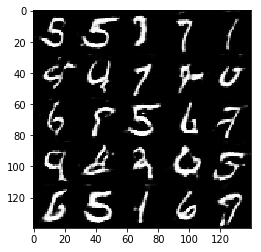

Epoch 2/2... Discriminator Loss: 0.6437... Generator Loss: 1.3476
Epoch 2/2... Discriminator Loss: 0.9672... Generator Loss: 4.1117
Epoch 2/2... Discriminator Loss: 0.7802... Generator Loss: 1.1031
Epoch 2/2... Discriminator Loss: 0.4024... Generator Loss: 1.7147
Epoch 2/2... Discriminator Loss: 0.8738... Generator Loss: 0.8976
Epoch 2/2... Discriminator Loss: 1.1352... Generator Loss: 0.7214
Epoch 2/2... Discriminator Loss: 0.7078... Generator Loss: 3.2065
Epoch 2/2... Discriminator Loss: 0.8462... Generator Loss: 1.1689
Epoch 2/2... Discriminator Loss: 1.6927... Generator Loss: 0.5005
Epoch 2/2... Discriminator Loss: 2.0135... Generator Loss: 0.3245


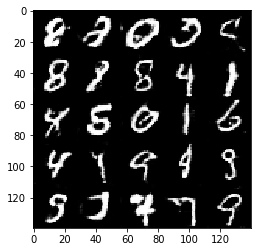

Epoch 2/2... Discriminator Loss: 0.6779... Generator Loss: 1.6320
Epoch 2/2... Discriminator Loss: 2.4347... Generator Loss: 0.1755
Epoch 2/2... Discriminator Loss: 0.4246... Generator Loss: 1.8965
Epoch 2/2... Discriminator Loss: 0.6363... Generator Loss: 2.8371
Epoch 2/2... Discriminator Loss: 2.2566... Generator Loss: 0.2673
Epoch 2/2... Discriminator Loss: 0.9757... Generator Loss: 0.9016
Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 0.5324
Epoch 2/2... Discriminator Loss: 0.4221... Generator Loss: 1.9867
Epoch 2/2... Discriminator Loss: 0.8976... Generator Loss: 0.9853
Epoch 2/2... Discriminator Loss: 0.7133... Generator Loss: 1.1471


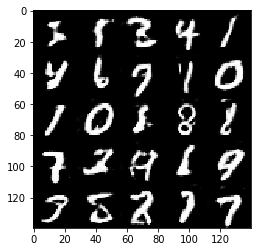

Epoch 2/2... Discriminator Loss: 0.7696... Generator Loss: 1.0919
Epoch 2/2... Discriminator Loss: 1.0332... Generator Loss: 0.8109
Epoch 2/2... Discriminator Loss: 0.1983... Generator Loss: 2.9783
Epoch 2/2... Discriminator Loss: 0.9061... Generator Loss: 0.9400
Epoch 2/2... Discriminator Loss: 0.9783... Generator Loss: 2.6660
Epoch 2/2... Discriminator Loss: 1.0188... Generator Loss: 1.4805
Epoch 2/2... Discriminator Loss: 2.2569... Generator Loss: 0.2860
Epoch 2/2... Discriminator Loss: 0.5605... Generator Loss: 1.7489
Epoch 2/2... Discriminator Loss: 0.9809... Generator Loss: 1.0050
Epoch 2/2... Discriminator Loss: 0.3567... Generator Loss: 2.1063


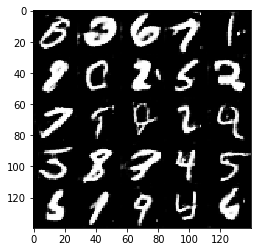

Epoch 2/2... Discriminator Loss: 0.8430... Generator Loss: 2.0354
Epoch 2/2... Discriminator Loss: 0.9498... Generator Loss: 0.8051
Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 0.9715
Epoch 2/2... Discriminator Loss: 0.8182... Generator Loss: 0.9206
Epoch 2/2... Discriminator Loss: 1.3599... Generator Loss: 0.4977
Epoch 2/2... Discriminator Loss: 1.4125... Generator Loss: 3.7718
Epoch 2/2... Discriminator Loss: 0.4772... Generator Loss: 1.9006
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 0.7657
Epoch 2/2... Discriminator Loss: 0.4943... Generator Loss: 1.5598
Epoch 2/2... Discriminator Loss: 0.6859... Generator Loss: 1.2231


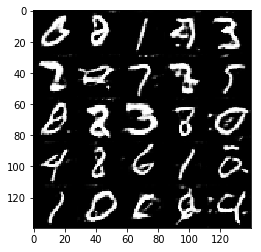

Epoch 2/2... Discriminator Loss: 0.6701... Generator Loss: 1.3941
Epoch 2/2... Discriminator Loss: 0.8568... Generator Loss: 2.4772
Epoch 2/2... Discriminator Loss: 0.6899... Generator Loss: 2.7480
Epoch 2/2... Discriminator Loss: 0.8961... Generator Loss: 1.2036
Epoch 2/2... Discriminator Loss: 1.4776... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 0.6180... Generator Loss: 1.7740
Epoch 2/2... Discriminator Loss: 1.3021... Generator Loss: 0.5706
Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 0.7498
Epoch 2/2... Discriminator Loss: 0.6210... Generator Loss: 1.1988
Epoch 2/2... Discriminator Loss: 1.2732... Generator Loss: 0.6182


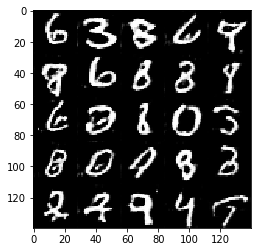

Epoch 2/2... Discriminator Loss: 3.0816... Generator Loss: 0.1137
Epoch 2/2... Discriminator Loss: 0.3887... Generator Loss: 1.7749
Epoch 2/2... Discriminator Loss: 0.2559... Generator Loss: 2.0863
Epoch 2/2... Discriminator Loss: 0.8231... Generator Loss: 0.9169
Epoch 2/2... Discriminator Loss: 3.1486... Generator Loss: 0.1958
Epoch 2/2... Discriminator Loss: 0.3619... Generator Loss: 2.9492
Epoch 2/2... Discriminator Loss: 0.9533... Generator Loss: 1.0269
Epoch 2/2... Discriminator Loss: 0.9159... Generator Loss: 1.1675
Epoch 2/2... Discriminator Loss: 0.8319... Generator Loss: 1.9928
Epoch 2/2... Discriminator Loss: 1.1866... Generator Loss: 0.7004


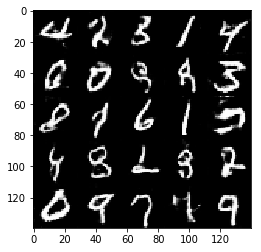

Epoch 2/2... Discriminator Loss: 0.6133... Generator Loss: 1.3393
Epoch 2/2... Discriminator Loss: 0.2413... Generator Loss: 2.5949
Epoch 2/2... Discriminator Loss: 0.5017... Generator Loss: 2.8420
Epoch 2/2... Discriminator Loss: 0.7020... Generator Loss: 1.0559
Epoch 2/2... Discriminator Loss: 0.5170... Generator Loss: 1.7612
Epoch 2/2... Discriminator Loss: 0.9778... Generator Loss: 0.8243
Epoch 2/2... Discriminator Loss: 1.9109... Generator Loss: 0.3830
Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 1.2176
Epoch 2/2... Discriminator Loss: 1.3313... Generator Loss: 0.5203
Epoch 2/2... Discriminator Loss: 1.1521... Generator Loss: 3.2533


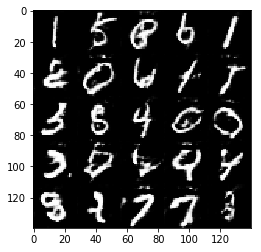

Epoch 2/2... Discriminator Loss: 1.8519... Generator Loss: 0.3069
Epoch 2/2... Discriminator Loss: 0.8804... Generator Loss: 2.5864
Epoch 2/2... Discriminator Loss: 0.6747... Generator Loss: 1.3433
Epoch 2/2... Discriminator Loss: 1.0979... Generator Loss: 0.6420
Epoch 2/2... Discriminator Loss: 0.4377... Generator Loss: 2.1034
Epoch 2/2... Discriminator Loss: 0.5336... Generator Loss: 1.4121
Epoch 2/2... Discriminator Loss: 0.6274... Generator Loss: 1.0391
Epoch 2/2... Discriminator Loss: 0.5922... Generator Loss: 2.0565
Epoch 2/2... Discriminator Loss: 1.1420... Generator Loss: 0.7998
Epoch 2/2... Discriminator Loss: 1.1928... Generator Loss: 0.6893


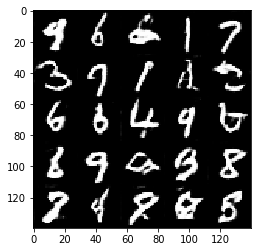

Epoch 2/2... Discriminator Loss: 0.4297... Generator Loss: 2.4972
Epoch 2/2... Discriminator Loss: 0.9866... Generator Loss: 3.2010
Epoch 2/2... Discriminator Loss: 0.5920... Generator Loss: 1.1296
Epoch 2/2... Discriminator Loss: 0.4262... Generator Loss: 2.1574
Epoch 2/2... Discriminator Loss: 1.6134... Generator Loss: 0.4518
Epoch 2/2... Discriminator Loss: 0.8584... Generator Loss: 1.3458
Epoch 2/2... Discriminator Loss: 2.0992... Generator Loss: 0.3081
Epoch 2/2... Discriminator Loss: 0.7392... Generator Loss: 1.0251
Epoch 2/2... Discriminator Loss: 1.1965... Generator Loss: 0.5866
Epoch 2/2... Discriminator Loss: 2.3958... Generator Loss: 0.1920


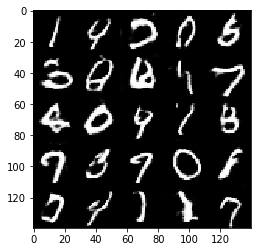

Epoch 2/2... Discriminator Loss: 1.8634... Generator Loss: 0.2246
Epoch 2/2... Discriminator Loss: 2.1603... Generator Loss: 0.2317
Epoch 2/2... Discriminator Loss: 0.8003... Generator Loss: 1.1074
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 0.4905
Epoch 2/2... Discriminator Loss: 0.5983... Generator Loss: 1.5551
Epoch 2/2... Discriminator Loss: 0.3002... Generator Loss: 1.8605
Epoch 2/2... Discriminator Loss: 0.4065... Generator Loss: 1.7346
Epoch 2/2... Discriminator Loss: 0.3761... Generator Loss: 2.3587
Epoch 2/2... Discriminator Loss: 0.2165... Generator Loss: 2.5366
Epoch 2/2... Discriminator Loss: 1.4249... Generator Loss: 0.4663


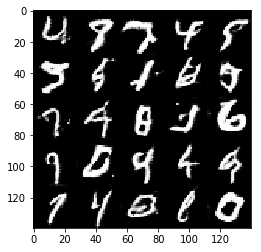

Epoch 2/2... Discriminator Loss: 2.3597... Generator Loss: 0.3688
Epoch 2/2... Discriminator Loss: 1.7147... Generator Loss: 0.5176
Epoch 2/2... Discriminator Loss: 0.9800... Generator Loss: 0.9272
Epoch 2/2... Discriminator Loss: 0.3243... Generator Loss: 1.8262
Epoch 2/2... Discriminator Loss: 0.4710... Generator Loss: 2.7712
Epoch 2/2... Discriminator Loss: 0.6128... Generator Loss: 1.4406
Epoch 2/2... Discriminator Loss: 0.5930... Generator Loss: 1.2012
Epoch 2/2... Discriminator Loss: 0.8315... Generator Loss: 0.9034
Epoch 2/2... Discriminator Loss: 0.6089... Generator Loss: 1.5823
Epoch 2/2... Discriminator Loss: 0.5199... Generator Loss: 1.6879


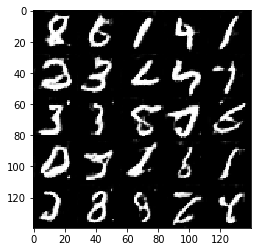

Epoch 2/2... Discriminator Loss: 0.9430... Generator Loss: 0.8802
Epoch 2/2... Discriminator Loss: 0.6535... Generator Loss: 1.6963
Epoch 2/2... Discriminator Loss: 0.3514... Generator Loss: 1.8548
Epoch 2/2... Discriminator Loss: 1.1886... Generator Loss: 0.6254
Epoch 2/2... Discriminator Loss: 1.4808... Generator Loss: 0.4188
Epoch 2/2... Discriminator Loss: 0.3196... Generator Loss: 1.7819
Epoch 2/2... Discriminator Loss: 0.3685... Generator Loss: 1.7533
Epoch 2/2... Discriminator Loss: 0.8481... Generator Loss: 1.2854
Epoch 2/2... Discriminator Loss: 0.3375... Generator Loss: 2.2999
Epoch 2/2... Discriminator Loss: 0.5075... Generator Loss: 1.4716


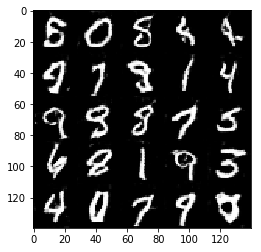

Epoch 2/2... Discriminator Loss: 1.3385... Generator Loss: 0.5753
Epoch 2/2... Discriminator Loss: 0.4858... Generator Loss: 1.6623
Epoch 2/2... Discriminator Loss: 0.1803... Generator Loss: 2.9279
Epoch 2/2... Discriminator Loss: 0.2552... Generator Loss: 2.3918
Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 0.8469
Epoch 2/2... Discriminator Loss: 0.6481... Generator Loss: 2.0139
Epoch 2/2... Discriminator Loss: 2.5861... Generator Loss: 0.1886
Epoch 2/2... Discriminator Loss: 0.2685... Generator Loss: 2.5506
Epoch 2/2... Discriminator Loss: 0.8306... Generator Loss: 0.9354
Epoch 2/2... Discriminator Loss: 0.7038... Generator Loss: 1.3843


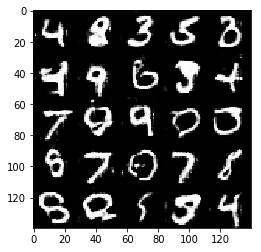

Epoch 2/2... Discriminator Loss: 0.9142... Generator Loss: 0.8435
Epoch 2/2... Discriminator Loss: 0.5533... Generator Loss: 1.7830
Epoch 2/2... Discriminator Loss: 0.2407... Generator Loss: 4.1354
Epoch 2/2... Discriminator Loss: 0.3285... Generator Loss: 2.2205
Epoch 2/2... Discriminator Loss: 3.3662... Generator Loss: 0.1553
Epoch 2/2... Discriminator Loss: 1.6145... Generator Loss: 5.3895
Epoch 2/2... Discriminator Loss: 1.1595... Generator Loss: 0.7671
Epoch 2/2... Discriminator Loss: 1.0264... Generator Loss: 1.0331
Epoch 2/2... Discriminator Loss: 0.4713... Generator Loss: 1.7993
Epoch 2/2... Discriminator Loss: 0.4525... Generator Loss: 4.4836


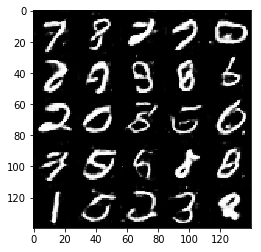

Epoch 2/2... Discriminator Loss: 0.8059... Generator Loss: 1.1584
Epoch 2/2... Discriminator Loss: 0.6385... Generator Loss: 1.2423
Epoch 2/2... Discriminator Loss: 1.4097... Generator Loss: 0.6254
Epoch 2/2... Discriminator Loss: 0.5322... Generator Loss: 1.4780
Epoch 2/2... Discriminator Loss: 0.4604... Generator Loss: 1.4002


In [25]:
batch_size = 32
z_dim = 100
learning_rate = 0.005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [26]:
batch_size = 32
z_dim = 100
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

KeyboardInterrupt: 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.